In [94]:
#importing Useful DataStructures
import pandas as pd
import numpy as np
from scipy.stats import uniform

import shap

#importing plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
from prettytable import PrettyTable
import plotly.express as px
import matplotlib.pyplot as plt

#importing Misc Libraries
import os
import gc
import pickle
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML(""))


#sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, auc, roc_curve, precision_recall_curve, roc_auc_score, precision_score, recall_score, average_precision_score, confusion_matrix, classification_report

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.impute   import SimpleImputer

#other modelling libraries
from bayes_opt import BayesianOptimization
import xgboost as xgb
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from catboost import CatBoostClassifier

import lightgbm as lgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor

plt.style.use('ggplot')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
    
import warnings
warnings.filterwarnings('ignore')

import plotly
plotly.io.orca.config.executable = 'C:/Users/Rishika/AppData/Local/Programs/orca/orca.exe'
plotly.offline.init_notebook_mode(connected=True)
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime

#for 100% jupyter notebook cell width
from IPython.core.display import display, HTML
display(HTML(""))

In [3]:
def reduce_mem_usage(data, verbose = True):
    #source: https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
    '''
    This function is used to reduce the memory usage by converting the datatypes of a pandas
    DataFrame withing required limits.
    '''
    
    start_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('-'*100)
        print('Memory usage of dataframe: {:.2f} MB'.format(start_mem))
    
    for col in data.columns:
        col_type = data[col].dtype
        
        if col_type != object:
            c_min = data[col].min()
            c_max = data[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    data[col] = data[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    data[col] = data[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    data[col] = data[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    data[col] = data[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    data[col] = data[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    data[col] = data[col].astype(np.float32)
                else:
                    data[col] = data[col].astype(np.float64)

    end_mem = data.memory_usage().sum() / 1024**2
    if verbose:
        print('Memory usage after optimization: {:.2f} MB'.format(end_mem))
        print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
        print('-'*100)
    
    return data

In [4]:
def load_all_tables(directory_path = '', verbose = True):
    
    '''
    Function to load all the tables required
    
    Input:
        directory_path: str, default = ''
            Path of directory in which tables are stored in
        verbose: bool, default = True
            Whether to keep verbosity or not
        
    '''
    
    if verbose:
        print("Loading all the tables...")
        start = datetime.now()
    
    #making all the variables global to be used anywhere in the notebook
    global application_train, application_test, bureau, bureau_balance, cc_balance, installments_payments, POS_CASH_balance, previous_application
    
    application_train = pd.read_csv(directory_path + 'application_train.csv')
    if verbose:
        print("Loaded 1 table.")
       
    application_test = pd.read_csv(directory_path + 'application_test.csv')
    if verbose:
        print("Loaded 2 tables.")

    bureau = pd.read_csv(directory_path + 'bureau.csv')
    if verbose:
        print("Loaded 3 tables.")

    bureau_balance = pd.read_csv(directory_path + 'bureau_balance.csv')
    if verbose:
        print("Loaded 4 tables.")

    cc_balance = pd.read_csv(directory_path + 'credit_card_balance.csv')
    if verbose:
        print("Loaded 5 tables.")

    installments_payments = pd.read_csv(directory_path + 'installments_payments.csv')
    if verbose:
        print("Loaded 6 tables.")

    POS_CASH_balance = pd.read_csv(directory_path + 'POS_CASH_balance.csv')
    if verbose:
        print("Loaded 7 tables.")

    previous_application = pd.read_csv(directory_path + 'previous_application.csv')
    if verbose:
        print("Loaded 8 tables.")
        print("Done.")
        print(f'Time Taken to load 8 tables = {datetime.now() - start}')

In [5]:
def nan_df_create(data):
    
    '''
    Function to create a dataframe of percentage of NaN values for each column of the dataframe
    
    Inputs:
        data: 
            DataFrame
    
    Returns:
        DataFrame of NaN percentages
    '''
    
    nan_percentages = data.isna().sum() * 100 / len(data)
    df = pd.DataFrame({'column' : nan_percentages.index, 'percent' : nan_percentages.values})
    
    #sorting the dataframe by decreasing order of percentage of NaN values
    df.sort_values(by = 'percent', ascending = False, inplace = True)
    
    return df

In [6]:
def plot_nan_percent(df_nan, title_name, tight_layout = True, figsize = (20,8), grid = False, rotation = 90):
    
    '''
    Function to plot Bar Plots of NaN percentages for each Column with missing values
    
    Inputs:
        df_nan: 
            DataFrame of NaN percentages
        title_name: 
            Name of table to be displayed in title of plot
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        figsize: tuple, default = (20,8)
            Figure size of plot    
        grid: bool, default = False
            Whether to draw gridlines to plot or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels

    '''
    
    #checking if there is any column with NaNs or not.
    if df_nan.percent.sum() != 0:
        print(f"Number of columns having NaN values: {df_nan[df_nan['percent'] != 0].shape[0]} columns")
        
        #plotting the Bar-Plot for NaN percentages (only for columns with Non-Zero percentage of NaN values)
        plt.figure(figsize = figsize, tight_layout = tight_layout)
        sns.barplot(x= 'column', y = 'percent', data = df_nan[df_nan['percent'] > 0])
        plt.xticks(rotation = rotation)
        plt.xlabel('Column Name')
        plt.ylabel('Percentage of NaN values')
        plt.title(f'Percentage of NaN values in {title_name}')
        if grid:
            plt.grid()
        plt.show()
    else:
        print(f"The dataframe {title_name} does not contain any NaN values.")

In [7]:
class correlation_matrix:
    '''
    Class to plot heatmap of Correlation Matrix and print Top Correlated Features with Target.
    Contains three methods:
        1. init method
        2. plot_correlation_matrix method
        3. target_top_corr method
    '''
    
    def __init__(self, data, columns_to_drop, figsize = (25,23), mask_upper = True, tight_layout = True, 
                  linewidth = 0.1, fontsize = 10, cmap = 'Blues'):  
        '''  
        Function to initialize the class members. 
        
        Inputs:
            data: DataFrame
                The DataFrame from which to build correlation matrix
            columns_to_drop: list
                Columns which have to be dropped while building the correlation matrix (for example the Loan ID)
            figsize: tuple, default = (25,23)
                Size of the figure to be plotted
            mask_upper: bool, default = True
                Whether to plot only the lower triangle of heatmap or plot full.
            tight_layout: bool, default = True
                Whether to keep tight layout or not
            linewidth: float/int, default = 0.1
                The linewidth to use for heatmap
            fontsize: int, default = 10
                The font size for the X and Y tick labels
            cmap: str, default = 'Blues'
                The colormap to be used for heatmap

        Returns:
            None
        '''
        
        self.data = data
        self.columns_to_drop = columns_to_drop
        self.figsize = figsize
        self.mask_upper = mask_upper
        self.tight_layout = tight_layout
        self.linewidth = linewidth
        self.fontsize = fontsize
        self.cmap = cmap 
                 
    def plot_correlation_matrix(self):
        '''
        Function to plot the Correlation Matrix Heatmap
        
        Inputs:
            self
        
        Returns:
            None
        '''
        
        print('-' * 100)
        #building the correlation dataframe
        self.corr_data = self.data.drop(self.columns_to_drop + ['TARGET'], axis = 1).corr()

        if self.mask_upper:
            #masking the heatmap to show only lower triangle. This is to save the RAM.
            mask_array = np.ones(self.corr_data.shape)
            mask_array = np.triu(mask_array)
        else:
            mask_array = np.zeros(self.corr_data.shape)

        plt.figure(figsize = self.figsize, tight_layout = self.tight_layout)
        sns.heatmap(self.corr_data, annot = False, mask = mask_array, linewidth = self.linewidth, cmap = self.cmap)
        plt.xticks(rotation = 90, fontsize = self.fontsize)
        plt.yticks(fontsize = self.fontsize)
        plt.title("Correlation Heatmap for Numerical features")
        plt.show()
        print("-"*100)
    
    def target_top_corr(self, target_top_columns = 10):
        '''
        Function to return the Top Correlated features with the Target
        
        Inputs:
            self
            target_top_columns: int, default = 10
                The number of top correlated features with target to display
            
        Returns:
            Top correlated features DataFrame.
        '''
        
        phik_target_arr = np.zeros(self.corr_data.shape[1])
        #calculating the Phik-Correlation with Target
        for index, column in enumerate(self.corr_data.columns):
            phik_target_arr[index] = self.data[['TARGET', column]].phik_matrix().iloc[0,1]
        #getting the top correlated columns and their values
        top_corr_target_df = pd.DataFrame({'Column Name': self.corr_data.columns, 'Phik-Correlation' : phik_target_arr})
        top_corr_target_df = top_corr_target_df.sort_values(by = 'Phik-Correlation', ascending = False)
        
        return top_corr_target_df.iloc[:target_top_columns]

In [8]:
def plot_phik_matrix(data, categorical_columns, figsize = (20,20), mask_upper = True, tight_layout = True, linewidth = 0.1, fontsize = 10, cmap = 'Blues', show_target_top_corr = True, target_top_columns = 10):
    
    '''
    Function to Phi_k matrix for categorical features
    
    Inputs:
        data: DataFrame
            The DataFrame from which to build correlation matrix
        categorical_columns: list
            List of categorical columns whose PhiK values are to be plotted
        figsize: tuple, default = (25,23)
            Size of the figure to be plotted
        mask_upper: bool, default = True
            Whether to plot only the lower triangle of heatmap or plot full.
        tight_layout: bool, default = True
            Whether to keep tight layout or not
        linewidth: float/int, default = 0.1
            The linewidth to use for heatmap
        fontsize: int, default = 10
            The font size for the X and Y tick labels
        cmap: str, default = 'Blues'
            The colormap to be used for heatmap
        show_target_top_corr: bool, default = True
            Whether to show top/highly correlated features with Target.
        target_top_columns: int, default = 10
            The number of top correlated features with target to display
    '''
    
    #first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype('object')
    phik_matrix = data_for_phik.phik_matrix()
    
    print('-'*100)
    
    if mask_upper:
        mask_array = np.ones(phik_matrix.shape)
        mask_array = np.triu(mask_array)
    else:
        mask_array = np.zeros(phik_matrix.shape)
        
    plt.figure(figsize = figsize, tight_layout = tight_layout)
    sns.heatmap(phik_matrix, annot = False, mask = mask_array, linewidth = linewidth, cmap = cmap)
    plt.xticks(rotation = 90, fontsize = fontsize)
    plt.yticks(rotation = 0, fontsize = fontsize)
    plt.title("Phi-K Correlation Heatmap for Categorical Features")
    plt.show()
    print("-"*100)

    if show_target_top_corr:
        #Seeing the top columns with highest correlation with the target variable in application_train
        print("Categories with highest values of Phi-K Correlation value with Target Variable are:")
        phik_df = pd.DataFrame({'Column Name' : phik_matrix.TARGET.index[1:], 'Phik-Correlation' : phik_matrix.TARGET.values[1:]})
        phik_df = phik_df.sort_values(by = 'Phik-Correlation', ascending = False)
        display(phik_df.head(target_top_columns))
        print("-"*100) 

In [9]:
def plot_categorical_variables_bar(data, column_name, figsize = (18,6), percentage_display = True, plot_defaulter = True, rotation = 0, horizontal_adjust = 0, fontsize_percent = 'xx-small'):
    
    '''
    Function to plot Categorical Variables Bar Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        figsize: tuple, default = (18,6)
            Size of the figure to be plotted
        percentage_display: bool, default = True
            Whether to display the percentages on top of Bars in Bar-Plot
        plot_defaulter: bool
            Whether to plot the Bar Plots for Defaulters or not
        rotation: int, default = 0
            Degree of rotation for x-tick labels
        horizontal_adjust: int, default = 0
            Horizontal adjustment parameter for percentages displayed on the top of Bars of Bar-Plot
        fontsize_percent: str, default = 'xx-small'
            Fontsize for percentage Display
        
    '''
    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)
    plt.show()


In [10]:
def plot_categorical_variables_pie(data, column_name, plot_defaulter = True, hole = 0):
    
    '''
    Function to plot categorical variables Pie Plots
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose distribution is to be plotted
        plot_defaulter: bool
            Whether to plot the Pie Plot for Defaulters or not
        hole: int, default = 0
            Radius of hole to be cut out from Pie Chart
    '''
    
    if plot_defaulter:
        cols = 2
        specs = [[{'type' : 'domain'}, {'type' : 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets', f'Percentage of Defaulters for each category of {column_name}']
    else:
        cols = 1
        specs = [[{'type': 'domain'}]]
        titles = [f'Distribution of {column_name} for all Targets']
        
    values_categorical = data[column_name].value_counts()
    labels_categorical = values_categorical.index
    
    fig = make_subplots(rows = 1, cols = cols, 
                       specs = specs, 
                       subplot_titles = titles)
    
    fig.add_trace(go.Pie(values = values_categorical, labels = labels_categorical, hole = hole, 
                         textinfo = 'label+percent', textposition = 'inside'), row = 1, col = 1)
    
    if plot_defaulter:
        percentage_defaulter_per_category = data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()
        percentage_defaulter_per_category.dropna(inplace = True)
        percentage_defaulter_per_category = percentage_defaulter_per_category.round(2)
        
        fig.add_trace(go.Pie(values = percentage_defaulter_per_category, labels = percentage_defaulter_per_category.index, 
                             hole = hole, textinfo = 'label+value', hoverinfo = 'label+value'), row = 1, col = 2)
        
    fig.update_layout(title = f'Distribution of {column_name}')
    fig.show()

In [11]:
def print_unique_categories(data, column_name, show_counts = False):
    
    '''
    Function to print the basic stats such as unique categories and their counts for categorical variables
    
        Inputs:
        data: DataFrame
            The DataFrame from which to print statistics
        column_name: str
            Column's name whose stats are to be printed
        show_counts: bool, default = False
            Whether to show counts of each category or not

    '''
    
    print('-'*100)
    print(f"The unique categories of '{column_name}' are:\n{data[column_name].unique()}")
    print('-'*100)
    
    if show_counts:
        print(f"Counts of each category are:\n{data[column_name].value_counts()}")
        print('-'*100)

In [12]:
def plot_cdf(data, column_name, log_scale = False, figsize = (12,8)):
    
    '''
    Function to plot CDF of a continuour variable
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot
        column_name: str
            Column's name whose CDF is to be plotted
        log_scale: bool, default = True
            Whether to use log-scale (for widely varying values) or not
        figsize: tuple, default = (12,8)
            The size of figure to be plotted    
    '''
    
        
    percentile_values = data[[column_name]].dropna().sort_values(by = column_name)
    percentile_values['Percentile'] = [ele / (len(percentile_values) - 1) for ele in range(len(percentile_values))]

    plt.figure(figsize = figsize)
    if log_scale:
        plt.xscale('log')
        plt.xlabel(column_name + ' - (log-scale)')
    else:
        plt.xlabel(column_name)
    plt.plot(percentile_values[column_name], percentile_values['Percentile'], color = 'red')
    plt.ylabel('Probability')
    plt.title('CDF of {}'.format(column_name))
    plt.show()

In [13]:
def print_percentiles(data, column_name, percentiles = None):
    
    '''
    Function to print percentile values for given column
    
    Inputs:
        data: DataFrame
            The DataFrame from which to print percentiles
        column_name: str
            Column's name whose percentiles are to be printed
        percentiles: list, default = None
            The list of percentiles to print, if not given, default are printed
    '''
    
    print('-'*100)
    if not percentiles:
        percentiles = list(range(0,80,25)) + list(range(90,101,2))
    for i in percentiles:
        print(f'The {i}th percentile value of {column_name} is {np.percentile(data[column_name].dropna(), i)}')
    print("-"*100)

In [14]:
def plot_continuous_variables(data, column_name, plots = ['distplot', 'CDF', 'box', 'violin'], scale_limits = None, figsize = (20,8), histogram = True, log_scale = False):
    
    '''
    Function to plot continuous variables distribution
    
    Inputs:
        data: DataFrame
            The DataFrame from which to plot.
        column_name: str
            Column's name whose distribution is to be plotted.
        plots: list, default = ['distplot', 'CDF', box', 'violin']
            List of plots to plot for Continuous Variable.
        scale_limits: tuple (left, right), default = None
            To control the limits of values to be plotted in case of outliers.
        figsize: tuple, default = (20,8)
            Size of the figure to be plotted.
        histogram: bool, default = True
            Whether to plot histogram along with distplot or not.
        log_scale: bool, default = False
            Whether to use log-scale for variables with outlying points.
    '''

    data_to_plot = data.copy()
    if scale_limits:
        #taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][(data[column_name] > scale_limits[0]) & (data[column_name] < scale_limits[1])]

    number_of_subplots = len(plots)
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)
        
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
            
        if ele == 'distplot':  
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')

        if ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

        if ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    plt.show()

In [15]:
load_all_tables()

Loading all the tables...
Loaded 1 table.
Loaded 2 tables.
Loaded 3 tables.
Loaded 4 tables.
Loaded 5 tables.
Loaded 6 tables.
Loaded 7 tables.
Loaded 8 tables.
Done.
Time Taken to load 8 tables = 0:00:31.797248


In [16]:
print('-'*100)
print(f'The shape of application_train.csv is: {application_train.shape}')
print('-'*100)
print(f'Number of duplicate values in application_train: {application_train.shape[0] - application_train.duplicated().shape[0]}')
print('-'*100)
display(application_train.head())

----------------------------------------------------------------------------------------------------
The shape of application_train.csv is: (307511, 122)
----------------------------------------------------------------------------------------------------
Number of duplicate values in application_train: 0
----------------------------------------------------------------------------------------------------


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


Number of columns having NaN values: 67 columns


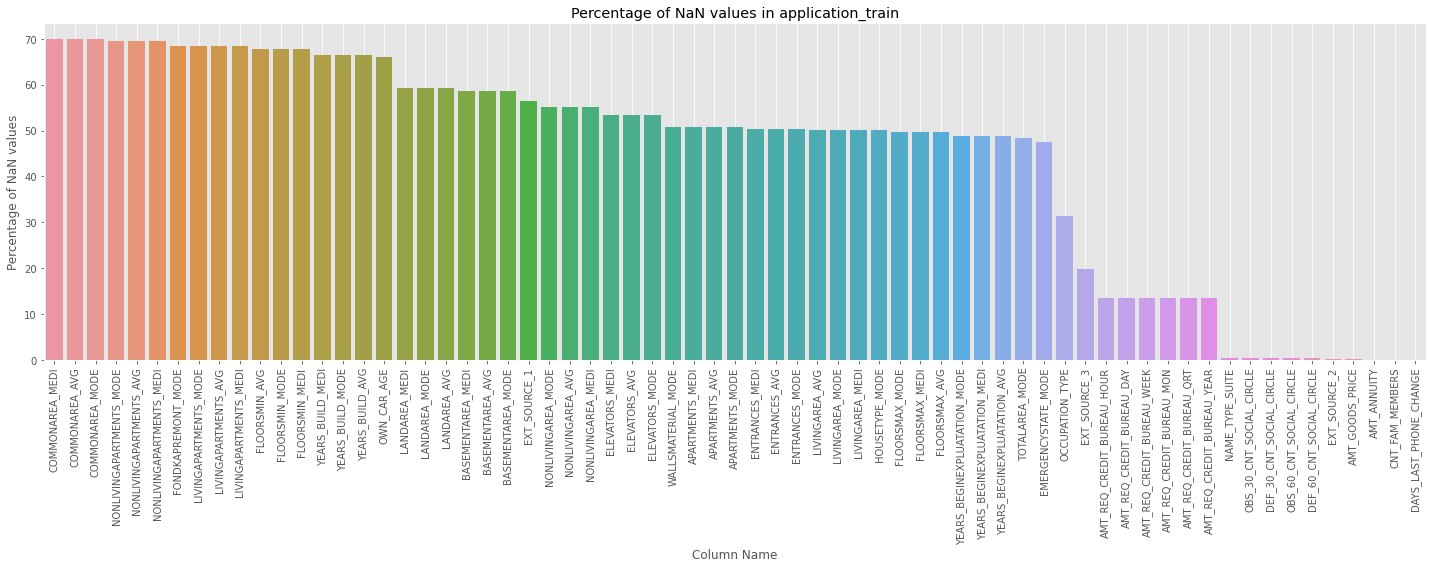

In [17]:
plot_nan_percent(nan_df_create(application_train), 'application_train', grid = True)

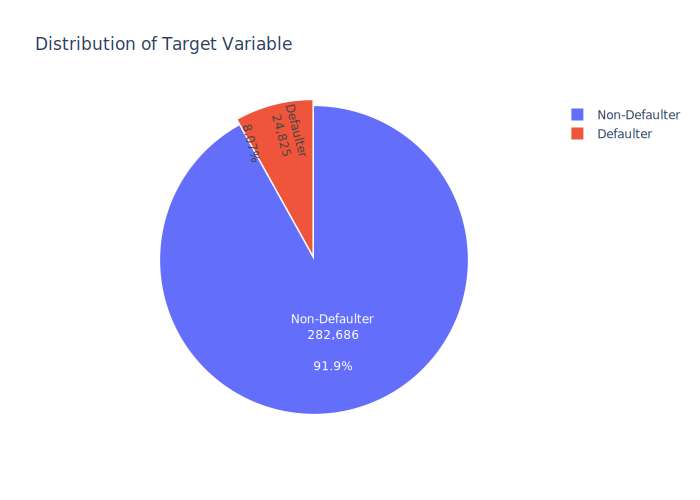

In [18]:
target_distribution = application_train.TARGET.value_counts()
labels = ['Non-Defaulter', 'Defaulter']

fig = go.Figure(data = [
        go.Pie(values = target_distribution, labels = labels, textinfo = 'label+percent+value' , pull = [0,0.04])], 
         layout = go.Layout(title = 'Distribution of Target Variable'))

fig.show(renderer = 'svg')

----------------------------------------------------------------------------------------------------


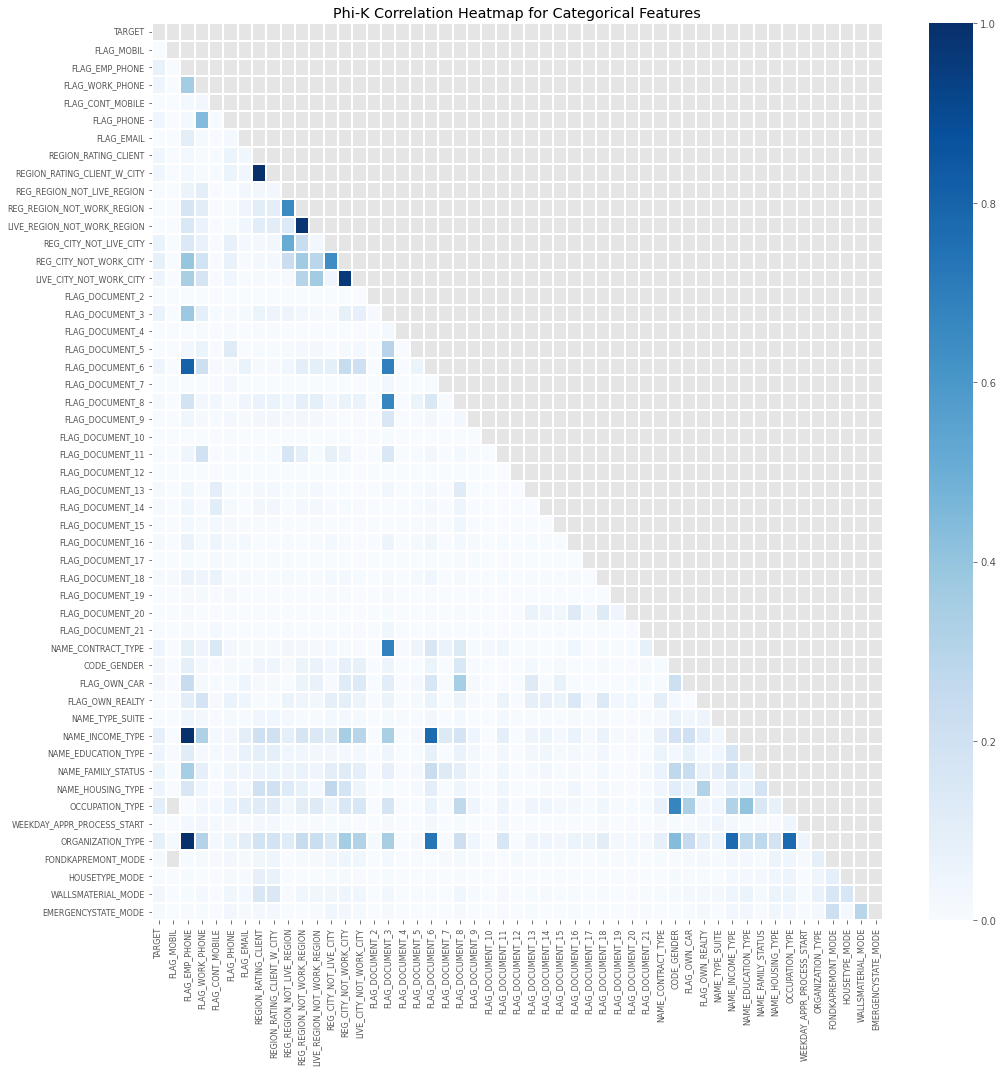

----------------------------------------------------------------------------------------------------
Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.102846
45,ORGANIZATION_TYPE,0.089164
39,NAME_INCOME_TYPE,0.084831
12,REG_CITY_NOT_WORK_CITY,0.079946
1,FLAG_EMP_PHONE,0.072087
11,REG_CITY_NOT_LIVE_CITY,0.069588
15,FLAG_DOCUMENT_3,0.069525
41,NAME_FAMILY_STATUS,0.056043
42,NAME_HOUSING_TYPE,0.051107
13,LIVE_CITY_NOT_WORK_CITY,0.050956


----------------------------------------------------------------------------------------------------


In [19]:
categorical_columns = ['TARGET','FLAG_MOBIL', 'FLAG_EMP_PHONE', 'FLAG_WORK_PHONE', 'FLAG_CONT_MOBILE',
                                   'FLAG_PHONE', 'FLAG_EMAIL','REGION_RATING_CLIENT','REGION_RATING_CLIENT_W_CITY',
                                  'REG_REGION_NOT_LIVE_REGION', 'REG_REGION_NOT_WORK_REGION', 'LIVE_REGION_NOT_WORK_REGION',
                                   'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 
                                'LIVE_CITY_NOT_WORK_CITY'] + ['FLAG_DOCUMENT_' + str(i) for i in range(2,22)] + application_train.dtypes[
                                    application_train.dtypes == 'object'].index.tolist()
plot_phik_matrix(application_train, categorical_columns, figsize = (15,15), fontsize = 8)


----------------------------------------------------------------------------------------------------


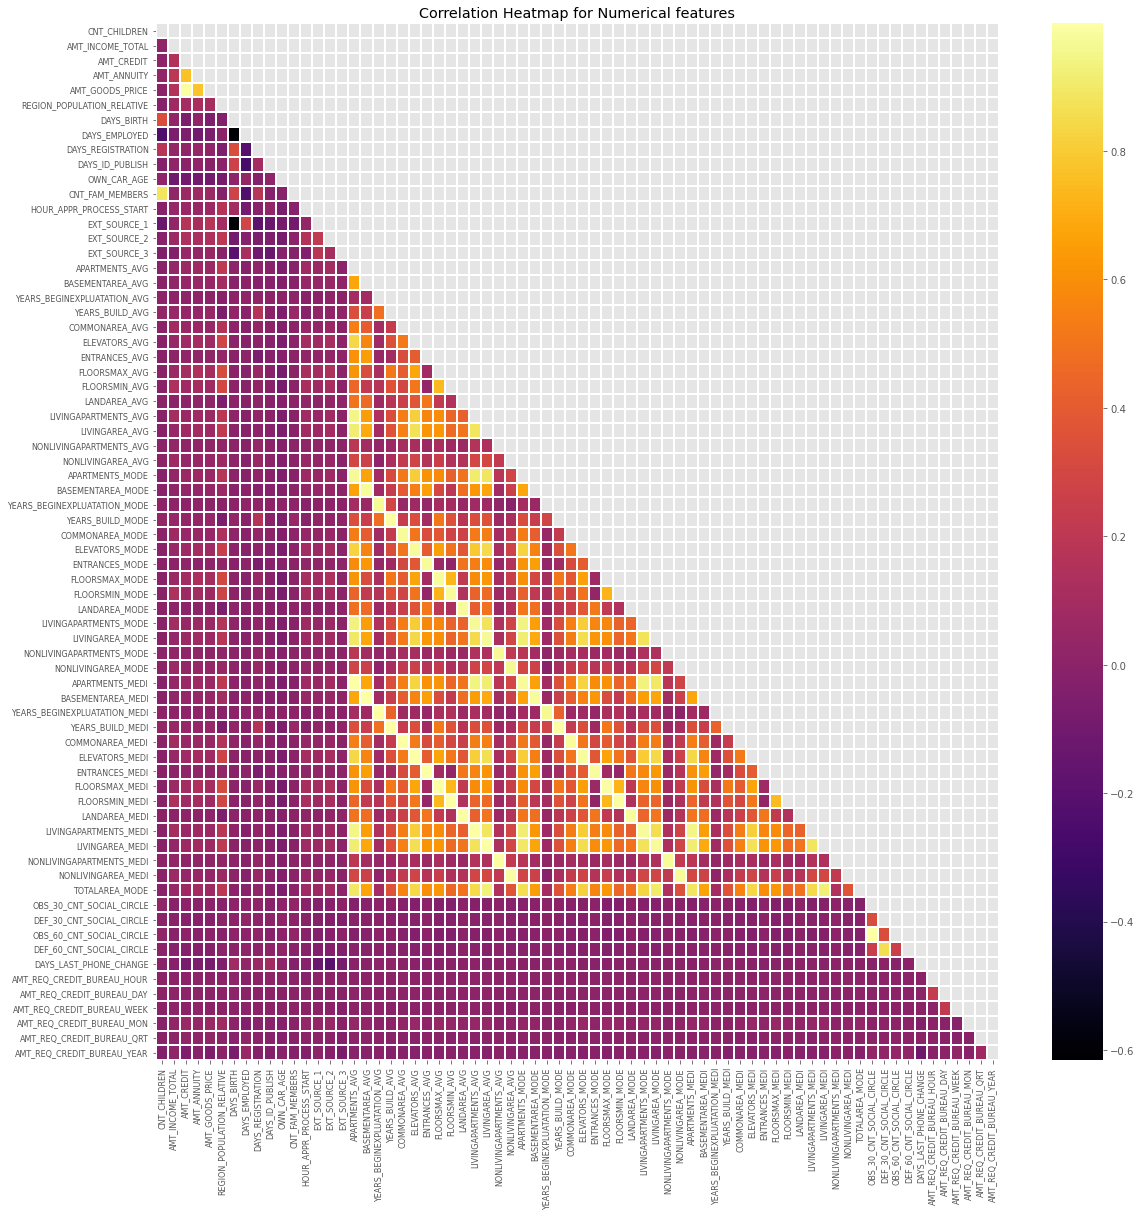

----------------------------------------------------------------------------------------------------


In [20]:
columns_to_drop = ['SK_ID_CURR'] + list(set(categorical_columns) - set(['TARGET']))
corr_mat = correlation_matrix(application_train, columns_to_drop, figsize = (17,17), fontsize = 8, cmap = 'inferno')
corr_mat.plot_correlation_matrix()

In [21]:
#Seeing the top columns with highest phik-correlation with the target variable in application_train table
top_corr_target_df = corr_mat.target_top_corr()
print("-" * 100)
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)
print("-"*100)


interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

,Column Name,Phik-Correlation
15,EXT_SOURCE_3,0.247680
13,EXT_SOURCE_1,0.217846
14,EXT_SOURCE_2,0.213965
6,DAYS_BIRTH,0.102378
63,DAYS_LAST_PHONE_CHANGE,0.073218
7,DAYS_EMPLOYED,0.072095
9,DAYS_ID_PUBLISH,0.067766
4,AMT_GOODS_PRICE,0.059094
23,FLOORSMAX_AVG,0.058826
51,FLOORSMAX_MEDI,0.058595


----------------------------------------------------------------------------------------------------


In [23]:
df = pd.read_csv('application_train.csv')

In [25]:
df_dbirth = (df['DAYS_BIRTH']/-365)

In [55]:
df_dipublish = (df['DAYS_ID_PUBLISH']/-365)

In [27]:
df_demployed = (df['DAYS_EMPLOYED']/-365)

In [56]:
df1 = df[['TARGET','REGION_RATING_CLIENT_W_CITY','OCCUPATION_TYPE','ORGANIZATION_TYPE','NAME_INCOME_TYPE','REG_CITY_NOT_WORK_CITY','FLAG_EMP_PHONE','REG_CITY_NOT_LIVE_CITY','FLAG_DOCUMENT_3','EXT_SOURCE_3','EXT_SOURCE_1','EXT_SOURCE_2','DAYS_LAST_PHONE_CHANGE']]

In [57]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   TARGET                       307511 non-null  int64  
 1   REGION_RATING_CLIENT_W_CITY  307511 non-null  int64  
 2   OCCUPATION_TYPE              211120 non-null  object 
 3   ORGANIZATION_TYPE            307511 non-null  object 
 4   NAME_INCOME_TYPE             307511 non-null  object 
 5   REG_CITY_NOT_WORK_CITY       307511 non-null  int64  
 6   FLAG_EMP_PHONE               307511 non-null  int64  
 7   REG_CITY_NOT_LIVE_CITY       307511 non-null  int64  
 8   FLAG_DOCUMENT_3              307511 non-null  int64  
 9   EXT_SOURCE_3                 246546 non-null  float64
 10  EXT_SOURCE_1                 134133 non-null  float64
 11  EXT_SOURCE_2                 306851 non-null  float64
 12  DAYS_LAST_PHONE_CHANGE       307510 non-null  float64
dtyp

In [58]:
df1.isna().sum()

TARGET                              0
REGION_RATING_CLIENT_W_CITY         0
OCCUPATION_TYPE                 96391
ORGANIZATION_TYPE                   0
NAME_INCOME_TYPE                    0
REG_CITY_NOT_WORK_CITY              0
FLAG_EMP_PHONE                      0
REG_CITY_NOT_LIVE_CITY              0
FLAG_DOCUMENT_3                     0
EXT_SOURCE_3                    60965
EXT_SOURCE_1                   173378
EXT_SOURCE_2                      660
DAYS_LAST_PHONE_CHANGE              1
dtype: int64

In [60]:
df1["OCCUPATION_TYPE"] = df1["OCCUPATION_TYPE"].fillna('Unknown')
df1

,TARGET,REGION_RATING_CLIENT_W_CITY,OCCUPATION_TYPE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,EXT_SOURCE_3,EXT_SOURCE_1,EXT_SOURCE_2,DAYS_LAST_PHONE_CHANGE
0,1,2,Laborers,Business Entity Type 3,Working,0,1,0,1,0.139376,0.083037,0.262949,-1134.0
1,0,1,Core staff,School,State servant,0,1,0,1,NaN,0.311267,0.622246,-828.0
2,0,2,Laborers,Government,Working,0,1,0,0,0.729567,NaN,0.555912,-815.0
3,0,2,Laborers,Business Entity Type 3,Working,0,1,0,1,NaN,NaN,0.650442,-617.0
4,0,2,Core staff,Religion,Working,1,1,0,0,NaN,NaN,0.322738,-1106.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,Sales staff,Services,Working,0,1,0,0,NaN,0.145570,0.681632,-273.0
307507,0,2,Unknown,XNA,Pensioner,0,0,0,1,NaN,NaN,0.115992,0.0
307508,0,3,Managers,School,Working,1,1,0,1,0.218859,0.744026,0.535722,-1909.0
307509,1,2,Laborers,Business Entity Type 1,Commercial associate,1,1,1,1,0.661024,NaN,0.514163,-322.0


In [45]:
df3 = pd.get_dummies(df2["NAME_INCOME_TYPE"], prefix='Income')
df3.head()

,Income_Businessman,Income_Commercial associate,Income_Maternity leave,Income_Pensioner,Income_State servant,Income_Student,Income_Unemployed,Income_Working
0,0,0,0,0,0,0,0,1
1,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,1


In [46]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 8 columns):
 #   Column                       Non-Null Count   Dtype
---  ------                       --------------   -----
 0   Income_Businessman           307511 non-null  uint8
 1   Income_Commercial associate  307511 non-null  uint8
 2   Income_Maternity leave       307511 non-null  uint8
 3   Income_Pensioner             307511 non-null  uint8
 4   Income_State servant         307511 non-null  uint8
 5   Income_Student               307511 non-null  uint8
 6   Income_Unemployed            307511 non-null  uint8
 7   Income_Working               307511 non-null  uint8
dtypes: uint8(8)
memory usage: 2.3 MB


In [47]:
df4 = pd.get_dummies(df2["OCCUPATION_TYPE"], prefix='Occupation')
df4.head()

,Occupation_Accountants,Occupation_Cleaning staff,Occupation_Cooking staff,Occupation_Core staff,Occupation_Drivers,Occupation_HR staff,Occupation_High skill tech staff,Occupation_IT staff,Occupation_Laborers,Occupation_Low-skill Laborers,Occupation_Managers,Occupation_Medicine staff,Occupation_Private service staff,Occupation_Realty agents,Occupation_Sales staff,Occupation_Secretaries,Occupation_Security staff,Occupation_Unknown,Occupation_Waiters/barmen staff
0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [48]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 19 columns):
 #   Column                            Non-Null Count   Dtype
---  ------                            --------------   -----
 0   Occupation_Accountants            307511 non-null  uint8
 1   Occupation_Cleaning staff         307511 non-null  uint8
 2   Occupation_Cooking staff          307511 non-null  uint8
 3   Occupation_Core staff             307511 non-null  uint8
 4   Occupation_Drivers                307511 non-null  uint8
 5   Occupation_HR staff               307511 non-null  uint8
 6   Occupation_High skill tech staff  307511 non-null  uint8
 7   Occupation_IT staff               307511 non-null  uint8
 8   Occupation_Laborers               307511 non-null  uint8
 9   Occupation_Low-skill Laborers     307511 non-null  uint8
 10  Occupation_Managers               307511 non-null  uint8
 11  Occupation_Medicine staff         307511 non-null  uint8
 12  Occupation_Priva

In [49]:
df5 = pd.get_dummies(df2["ORGANIZATION_TYPE"], prefix='Organization')
df5.head()

,Organization_Advertising,Organization_Agriculture,Organization_Bank,Organization_Business Entity Type 1,Organization_Business Entity Type 2,Organization_Business Entity Type 3,Organization_Cleaning,Organization_Construction,Organization_Culture,Organization_Electricity,...,Organization_Trade: type 4,Organization_Trade: type 5,Organization_Trade: type 6,Organization_Trade: type 7,Organization_Transport: type 1,Organization_Transport: type 2,Organization_Transport: type 3,Organization_Transport: type 4,Organization_University,Organization_XNA
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
df5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307511 entries, 0 to 307510
Data columns (total 58 columns):
 #   Column                               Non-Null Count   Dtype
---  ------                               --------------   -----
 0   Organization_Advertising             307511 non-null  uint8
 1   Organization_Agriculture             307511 non-null  uint8
 2   Organization_Bank                    307511 non-null  uint8
 3   Organization_Business Entity Type 1  307511 non-null  uint8
 4   Organization_Business Entity Type 2  307511 non-null  uint8
 5   Organization_Business Entity Type 3  307511 non-null  uint8
 6   Organization_Cleaning                307511 non-null  uint8
 7   Organization_Construction            307511 non-null  uint8
 8   Organization_Culture                 307511 non-null  uint8
 9   Organization_Electricity             307511 non-null  uint8
 10  Organization_Emergency               307511 non-null  uint8
 11  Organization_Government              30

In [62]:
df_update_new1 = pd.concat([df2, df3, df4, df5, df_dbirth, df_demployed, df_dipublish], axis = 1)
df_update_new1

,TARGET,REGION_RATING_CLIENT_W_CITY,OCCUPATION_TYPE,ORGANIZATION_TYPE,NAME_INCOME_TYPE,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,EXT_SOURCE_3,...,Organization_Trade: type 7,Organization_Transport: type 1,Organization_Transport: type 2,Organization_Transport: type 3,Organization_Transport: type 4,Organization_University,Organization_XNA,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_ID_PUBLISH
0,1,2,Laborers,Business Entity Type 3,Working,0,1,0,1,0.139376,...,0,0,0,0,0,0,0,25.920548,1.745205,5.808219
1,0,1,Core staff,School,State servant,0,1,0,1,NaN,...,0,0,0,0,0,0,0,45.931507,3.254795,0.797260
2,0,2,Laborers,Government,Working,0,1,0,0,0.729567,...,0,0,0,0,0,0,0,52.180822,0.616438,6.934247
3,0,2,Laborers,Business Entity Type 3,Working,0,1,0,1,NaN,...,0,0,0,0,0,0,0,52.068493,8.326027,6.676712
4,0,2,Core staff,Religion,Working,1,1,0,0,NaN,...,0,0,0,0,0,0,0,54.608219,8.323288,9.473973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
307506,0,1,Sales staff,Services,Working,0,1,0,0,NaN,...,0,0,0,0,0,0,0,25.553425,0.646575,5.430137
307507,0,2,Unknown,XNA,Pensioner,0,0,0,1,NaN,...,0,0,0,0,0,0,1,56.917808,-1000.665753,11.205479
307508,0,3,Managers,School,Working,1,1,0,1,0.218859,...,0,0,0,0,0,0,0,41.002740,21.701370,14.109589
307509,1,2,Laborers,Business Entity Type 1,Commercial associate,1,1,1,1,0.661024,...,0,0,0,0,0,0,0,32.769863,13.112329,2.550685


In [69]:
df_update_filter = df_update_new1.drop(['OCCUPATION_TYPE', 'ORGANIZATION_TYPE', 'NAME_INCOME_TYPE'], axis = 1)

In [72]:
df_update_filter.isna().sum().head(60)

TARGET                                      0
REGION_RATING_CLIENT_W_CITY                 0
REG_CITY_NOT_WORK_CITY                      0
FLAG_EMP_PHONE                              0
REG_CITY_NOT_LIVE_CITY                      0
FLAG_DOCUMENT_3                             0
EXT_SOURCE_3                            60965
EXT_SOURCE_1                           173378
EXT_SOURCE_2                              660
DAYS_LAST_PHONE_CHANGE                      1
Income_Businessman                          0
Income_Commercial associate                 0
Income_Maternity leave                      0
Income_Pensioner                            0
Income_State servant                        0
Income_Student                              0
Income_Unemployed                           0
Income_Working                              0
Occupation_Accountants                      0
Occupation_Cleaning staff                   0
Occupation_Cooking staff                    0
Occupation_Core staff             

In [73]:
apptrain = df_update_filter.fillna(0)

In [86]:
apptrain_save = apptrain.to_csv('apptrain_save.csv')

In [76]:
X = apptrain.loc[:, apptrain.columns != 'TARGET']
y = apptrain["TARGET"]

In [77]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4,
                                                   random_state=1)

In [96]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr = lr.fit(X_train, y_train)

In [104]:
import pickle
pickle.dump(lr, open("model_lr.pkl", "wb"))

In [98]:
from sklearn import tree
import pydotplus
import matplotlib.pyplot as plt
import matplotlib.image as pltimg

dtree = tree.DecisionTreeClassifier()
dtree = dtree.fit(X_train, y_train)

In [105]:
import pickle
pickle.dump(dtree, open("model_dtree.pkl", "wb"))

In [99]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [100]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [101]:
from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [102]:
grid_search.best_score_

0.9193088572725557

In [78]:
from sklearn.ensemble import RandomForestClassifier

classifier_rf = RandomForestClassifier(random_state=42, n_jobs=-1, max_depth=5,
                                       n_estimators=100, oob_score=True)

classifier_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_jobs=-1, oob_score=True, random_state=42)

In [79]:
prediction_rf = classifier_rf.predict(X_test)
print(accuracy_score(y_test, prediction_rf))
print(classification_report(y_test, prediction_rf))

0.919214666070485
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113068
           1       0.00      0.00      0.00      9937

    accuracy                           0.92    123005
   macro avg       0.46      0.50      0.48    123005
weighted avg       0.84      0.92      0.88    123005



In [81]:
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

In [103]:
import pickle
pickle.dump(classifier_rf, open("model_rf.pkl", "wb"))

In [82]:
params = {
    'max_depth': [2,3,5,10,20],
    'min_samples_leaf': [5,10,20,50,100,200],
    'n_estimators': [10,25,30,50,100,200]
}

In [90]:
from sklearn.model_selection import GridSearchCV

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf,
                           param_grid=params,
                           cv = 4,
                           n_jobs=-1, verbose=1, scoring="accuracy")

grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 180 candidates, totalling 720 fits


GridSearchCV(cv=4, estimator=RandomForestClassifier(n_jobs=-1, random_state=42),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 5, 10, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 100, 200],
                         'n_estimators': [10, 25, 30, 50, 100, 200]},
             scoring='accuracy', verbose=1)

In [91]:
grid_search.best_score_

0.9193088572725557

In [92]:
rf_best = grid_search.best_estimator_
rf_best.fit(X_train, y_train)

RandomForestClassifier(max_depth=20, min_samples_leaf=10, n_estimators=10,
                       n_jobs=-1, random_state=42)

In [93]:
## Evaluation

y_rf = rf_best.predict(X_test)

print(accuracy_score(y_test, y_rf))

print(precision_score(y_test, y_rf, average='macro'))

print(recall_score(y_test, y_rf, average='macro'))

print(confusion_matrix(y_test, y_rf))

fpr, tpr, thresholds = roc_curve(y_test, y_rf, pos_label=1) # pos_label: positive label
print(auc(fpr, tpr))

print(classification_report(y_test, y_rf))

0.9192065363196618
0.4596070046502553
0.4999955778823363
[[113067      1]
 [  9937      0]]
0.4999955778823363
              precision    recall  f1-score   support

           0       0.92      1.00      0.96    113068
           1       0.00      0.00      0.00      9937

    accuracy                           0.92    123005
   macro avg       0.46      0.50      0.48    123005
weighted avg       0.84      0.92      0.88    123005



In [106]:
y_lr = lr.predict(X_test)
y_dtree = dtree.predict(X_test)
y_rf = rf_best.predict(X_test)

In [107]:
from sklearn.metrics import precision_score
print(precision_score(y_test, y_lr, average='macro'))
print(precision_score(y_test, y_dtree, average='macro'))
print(precision_score(y_test, y_rf, average='macro'))

0.4596070046502553
0.5311987878046402
0.4596070046502553


In [108]:
from sklearn.metrics import recall_score
print(recall_score(y_test, y_lr, average='macro'))
print(recall_score(y_test, y_dtree, average='macro'))
print(recall_score(y_test, y_rf, average='macro'))

0.4999955778823363
0.533666399267022
0.4999955778823363


In [109]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_lr))
print(confusion_matrix(y_test, y_dtree))
print(confusion_matrix(y_test, y_rf))

[[113067      1]
 [  9937      0]]
[[103750   9318]
 [  8449   1488]]
[[113067      1]
 [  9937      0]]


In [110]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_lr, pos_label=1) # pos_label: positive label
print(auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_dtree, pos_label=1) # pos_label: positive label
print(auc(fpr, tpr))
fpr, tpr, thresholds = roc_curve(y_test, y_rf, pos_label=1) # pos_label: positive label
print(auc(fpr, tpr))

0.4999955778823363
0.533666399267022
0.4999955778823363
